In [1]:
#| output: false

import numpy as np
import matplotlib.pyplot as plt
import modules.functions as fs
from vxtools.summarize.structure import SummaryFile
from modules.dataloadr import MultiFish, SingleFish
from modules.plotstyle import PlotStyle
from sklearn.metrics import auc
from scipy.stats import pearsonr
from modules.contrast import selective_rois_trash, rg_activity_trash, phase_activity

ps = PlotStyle()

# now load the data
DATAROOT2 = '../data/data2/'
DATAROOT3 = '../data/data3/'
f2 = SummaryFile(DATAROOT2 + 'Summary.hdf5')
f3 = SummaryFile(DATAROOT3 + 'Summary.hdf5')
good_recs2 = [0, 1, 2, 4, 5]
good_recs3 = [0, 1, 2, 3, 4]

# load matrix of all rois of all layers with good rois
d2 = SingleFish(f2, good_recs2, overwrite=False)
d3 = SingleFish(f3, good_recs3, overwrite=False)

# load all fish in multifish class
mf = MultiFish([d2, d3])

/home/weygoldt/Data/uni/neuro_gp/calciumimaging/testcode/modules/functions.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Text(0, 0.5, 'ROI')

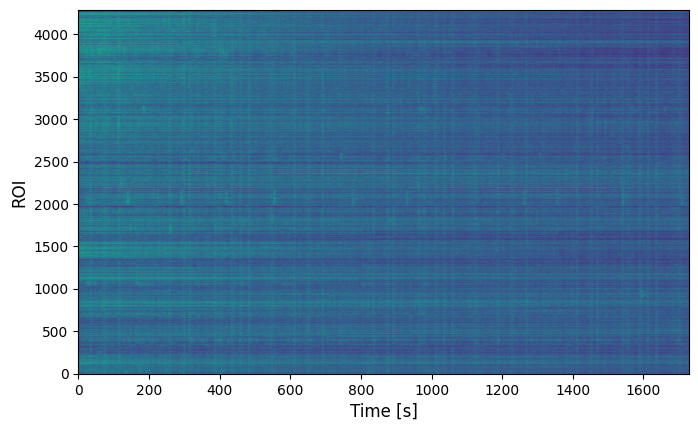

In [2]:
fig, ax = plt.subplots(figsize=(20*ps.cm, 12*ps.cm))
extent = (np.min(mf.times), np.max(mf.times), 0, len(mf.pmean_dffs[:,0]))
ax.imshow(mf.pmean_dffs, aspect='auto', extent=extent, origin='upper')
ax.set_xlabel('Time [s]')
ax.set_ylabel('ROI')

In [3]:
#| output: false

# Sort dff indices by correlation coefficient
mf.responding_rois()
mf.repeat_means()

# make a histpgram
counts, edges = np.histogram(mf.corrs[:, 1], bins=50, range=(-1,1), density=True)

# compute a gaussian KDE
xkde, kde = fs.kde1d(mf.corrs[:, 1], 0.02, xlims=[edges.min(), edges.max()])

[ roimatrix.sort_means_by_corr ] Computing autocorrelation for every dff ...:   0%|          | 0/…


[ roimatrix.repeat_means ] Computing means across repeats...
computed AreaUnderCurve (AUC) of KDE using sklearn.metrics.auc: 0.9999999603832244


Text(0, 0.5, 'Probability density')

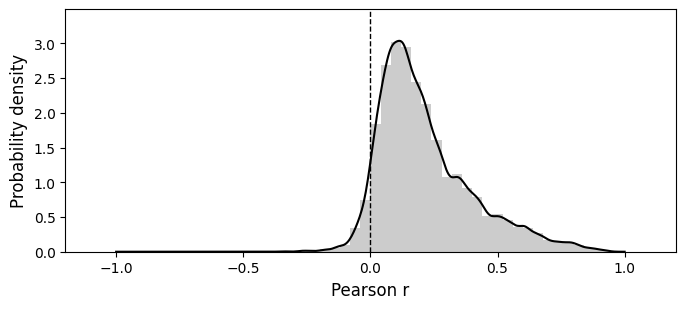

In [4]:
#| code-fold: true

fig, ax = plt.subplots(figsize=(20*ps.cm, 8*ps.cm))
ax.bar(edges[:-1], counts, width=np.diff(edges),edgecolor="white", facecolor="k", alpha=0.2,linewidth=0, align="edge", zorder=20)
ax.plot(xkde, kde, zorder=10, c="k")
ax.axvline([0], lw=1, ls="dashed", c="k")
ax.set_xlabel("Pearson r")
ax.set_ylabel("Probability density")

In [5]:
#| output: false

target_auc = 0.2 # probability threshold

# create empty arrays for the gradient and index
gradient = np.zeros_like(xkde[:-1])
index = np.arange(len(xkde[:-1]))

# compute the gradient between the target and actual auc
for i in range(len(xkde[:-1])):
    area = auc(xkde[i:], kde[i:])
    gradient[i] = abs(area-target_auc)

# find the index where the gradient is smallest
idx = index[gradient == gradient.min()][0]

Text(0.5, 0.01, 'Pearson r')

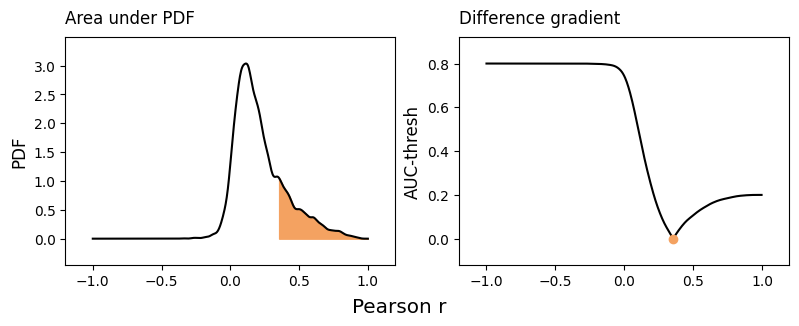

In [6]:
#| code-fold: true

# plot the gradient
fig, ax = plt.subplots(1,2,figsize=(20*ps.cm, 8*ps.cm), constrained_layout=True)
ax[0].plot(xkde, kde, c="k")
ax[0].fill_between(xkde[idx:], np.zeros_like(xkde[idx:]), kde[idx:], zorder=-10, alpha=1, color=ps.orange)
ax[0].set_title("Area under PDF")
ax[0].set_ylabel("PDF")
ax[1].plot(xkde[:-1], gradient, c="k")
ax[1].scatter(xkde[idx], gradient[idx], zorder=10, color=ps.orange)
ax[1].set_title("Difference gradient")
ax[1].set_ylabel("AUC-thresh")
fig.supxlabel("Pearson r")

In [7]:
#| output: false

# create a threshold
thresh = xkde[idx]

# get the rois
thresh_pmean_rois = fs.thresh_correlations(mf.corrs, thresh)

# get the phase and repeat mean dffs
active_pmean_rmean_dffs = np.array([mf.pmean_rmean_dffs[int(roi), :] for roi in thresh_pmean_rois[:,0]])

# get the phase mean dff
active_pmean_dffs = np.array([mf.pmean_dffs[int(roi), :] for roi in thresh_pmean_rois[:,0]])

# get their rois as well
active_pmean_rois = np.array([mf.rois[int(roi)] for roi in thresh_pmean_rois[:,0]])

# ... and the recording they came from
active_pmean_recs = np.array([mf.recs[int(roi)] for roi in thresh_pmean_rois[:,0]])

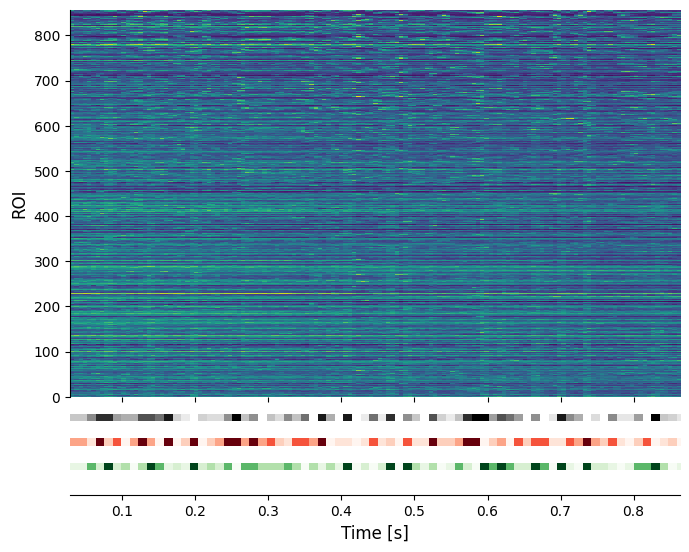

In [8]:
#| code-fold: true

# take only first repeat
idx = np.arange(mf.inx_pmean[0][0], mf.inx_pmean[0][1])

# luminance contrast: max(all)_stripe1 - max(all)_stripe2
stripe1 = np.array([np.max(x) for x in mf.red])
stripe2 = np.array([np.max(x) for x in mf.green])
lum_contr = abs(stripe1-stripe2)[mf.inx_pmean[0][0]:mf.inx_pmean[0][1]]

# color contrast: red_stripe1 - red_stripe2 (for red and green)
red = mf.red[:mf.inx_pmean[0][1]]
reds = np.array((red, red))
green = mf.green[:mf.inx_pmean[0][1]]
greens = np.array((green, green))

# make no rot = 0, counterclock = -1, clockwise = 1
ang_veloc = mf.ang_velocs[1:-1][mf.inx_pmean[0][0]:mf.inx_pmean[0][1]]
norots = np.full(len(mf.ang_velocs), np.nan)
leftrots = np.full(len(mf.ang_velocs), np.nan)
rightrots = np.full(len(mf.ang_velocs), np.nan)

for i, rot in enumerate(mf.ang_velocs):
    if rot > 0.0:
        rightrots[i] = 0
    elif rot == 0.0:
        norots[i] = 0
    else:
        leftrots[i] = 0

lum_img = np.empty((len(thresh_pmean_rois[0]), len(lum_contr)))
for i in range(len(lum_img[:, 0])):
    lum_img[i, :] = lum_contr

# plot the raster
fig, ax = plt.subplots(5, 1,
                       figsize=(20*ps.cm, 16*ps.cm),
                       gridspec_kw={'height_ratios': [10, 0.2, 0.2, 0.2, 0.2]},
                       sharex=True,
                       )

extent = (np.min(mf.pmean_rmean_dffs), np.max(mf.pmean_rmean_dffs), 0, len(active_pmean_rmean_dffs))

ax[0].imshow(active_pmean_rmean_dffs, aspect="auto", extent=extent, origin="upper", interpolation="none")


# plot contrast
ax[1].imshow(lum_img,
             cmap="binary",
             alpha=1,
             aspect="auto",
             extent=extent,
             interpolation="none",
             )
ax[2].imshow(reds,
             cmap="Reds",
             aspect="auto",
             extent=extent,
             interpolation="none",
             )
ax[3].imshow(greens,
             cmap="Greens",
             aspect="auto",
             extent=extent,
             interpolation="none",
             )

ps.hide_helper_xax(ax[1])
ps.hide_helper_xax(ax[2])
ps.hide_helper_xax(ax[3])

# remove upper and right axis
ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].spines["bottom"].set_visible(False)
ax[4].spines["right"].set_visible(False)
ax[4].spines["top"].set_visible(False)
ax[4].spines["left"].set_visible(False)
ax[4].tick_params(left=False, labelleft=False)

ax[4].set_xlabel("Time [s]")
ax[0].set_ylabel("ROI")
plt.show()

In [9]:
#| output: false

# motion regressor
motion = np.array([1 if x != 0 else 0 for x in mf.ang_velocs])

# clockwise motion regressor
clock = np.array([1 if x > 0 else 0 for x in mf.ang_velocs])

# counterclockwise motion regressor
cclock = np.array([1 if x < 0 else 0 for x in mf.ang_velocs])

In [10]:
#| output: false

corr_motion = np.array([pearsonr(x, motion)[0] for x in active_pmean_dffs])
corr_clock = np.array([pearsonr(x, clock)[0] for x in active_pmean_dffs])
corr_cclock = np.array([pearsonr(x, cclock)[0] for x in active_pmean_dffs])

Text(0.02, 0.5, 'Count')

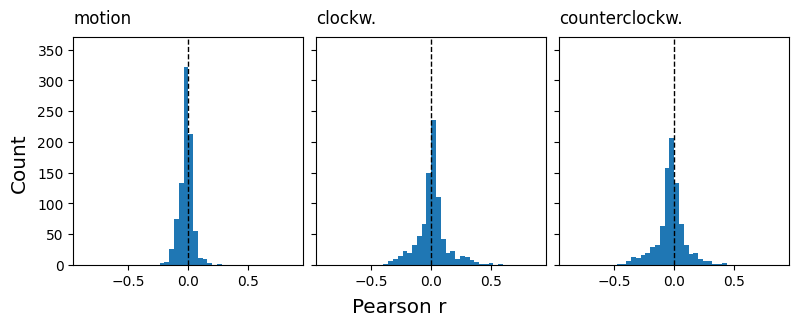

In [11]:
#| code-fold: true
fig, ax = plt.subplots(1,3, figsize=(20*ps.cm, 8*ps.cm), sharex=True, sharey=True, constrained_layout=True)
ax[0].hist(corr_motion, bins=40, range=(-0.8,0.8))
ax[0].axvline(0, lw=1, linestyle='dashed', c='k')
ax[1].hist(corr_clock, bins=40, range=(-0.8,0.8))
ax[1].axvline(0, lw=1, linestyle='dashed', c='k')
ax[2].hist(corr_cclock, bins=40, range=(-0.8,0.8))
ax[2].axvline(0, lw=1, linestyle='dashed', c='k')
ax[0].set_title("motion")
ax[1].set_title("clockw.")
ax[2].set_title("counterclockw.")
fig.supxlabel("Pearson r")
fig.supylabel("Count")

In [12]:
#| output: false

# make chromatic contrasts
red_contr = mf.red
green_contr = mf.green

# make achromatic contrast as the difference between the sums of both stripes
acr_contr = np.array([abs(x - y) for x, y in zip(mf.red, mf.green)])

In [13]:
#| output: false

corr_red = np.array([pearsonr(x, red_contr)[0] for x in active_pmean_dffs])
corr_green = np.array([pearsonr(x, green_contr)[0] for x in active_pmean_dffs])
corr_acr = np.array([pearsonr(x, acr_contr)[0] for x in active_pmean_dffs])

Text(0.02, 0.5, 'Count')

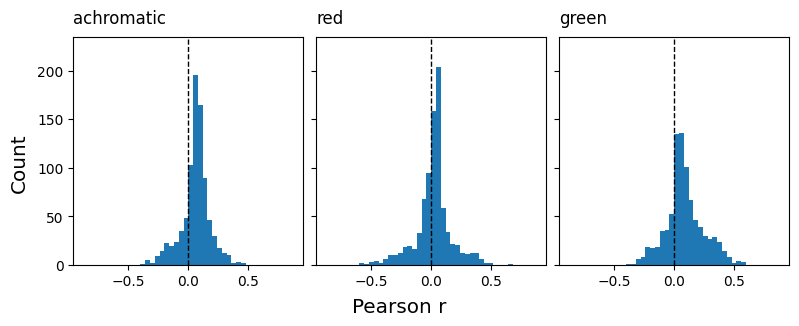

In [14]:
#| code-fold: true

fig, ax = plt.subplots(1,3, figsize=(20*ps.cm, 8*ps.cm), sharex=True, sharey=True, constrained_layout=True)
ax[0].hist(corr_acr, bins=40, range=(-0.8,0.8))
ax[0].axvline(0, lw=1, linestyle='dashed', c='k')
ax[1].hist(corr_red, bins=40, range=(-0.8,0.8))
ax[1].axvline(0, lw=1, linestyle='dashed', c='k')
ax[2].hist(corr_green, bins=40, range=(-0.8,0.8))
ax[2].axvline(0, lw=1, linestyle='dashed', c='k')
ax[0].set_title("achromatic")
ax[1].set_title("red")
ax[2].set_title("green")
fig.supxlabel("Pearson r")
fig.supylabel("Count")

Text(0.02, 0.5, 'Count')

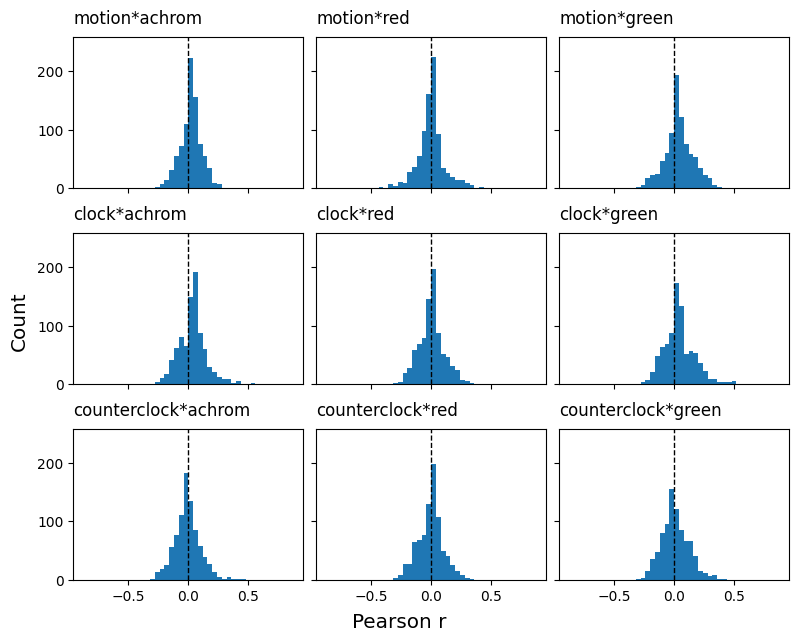

In [15]:
motions = [motion, clock, cclock]
motions_string = ["motion", "clock", "counterclock"]
contr = [acr_contr, red_contr, green_contr]
contr_string = ["achrom", "red", "green"]

fig, axs = plt.subplots(3,3, figsize=(20*ps.cm, 16*ps.cm), sharex=True, sharey=True, constrained_layout=True)

for i1, m in enumerate(motions):
  for i2, c in enumerate(contr):
    reg = c*m
    corr = np.array([pearsonr(x, reg)[0] for x in active_pmean_dffs])
    title = motions_string[i1] + '*' + contr_string[i2]
    n, bins, patches = axs[i1, i2].hist(corr, bins=40, range=(-0.8,0.8))
    axs[i1, i2].axvline(0, lw=1, linestyle='dashed', c='k')
    axs[i1, i2].set_title(title)
fig.supxlabel('Pearson r')
fig.supylabel('Count')

In [16]:
#| output: false

# build stimulus
clock_acr = np.array(clock * acr_contr)
cclock_acr = np.array(cclock * acr_contr)

# correlate
corr_clock_acr = np.array([pearsonr(clock_acr, x)[0] for x in active_pmean_dffs])
corr_cclock_acr = np.array([pearsonr(cclock_acr, x)[0] for x in active_pmean_dffs])

# make index vector
index = np.arange(len(corr_clock_acr))

# make threshold
thresh = 0.3

# use threshold to get index
index_clock_acr = index[corr_clock_acr > thresh]
index_cclock_acr = index[corr_cclock_acr > thresh]

# use the index to get the dff data
dffs_clock_acr = active_pmean_dffs[index_clock_acr, :]
dffs_cclock_acr = active_pmean_dffs[index_cclock_acr, :]

Text(0.02, 0.5, 'Norm. activity')

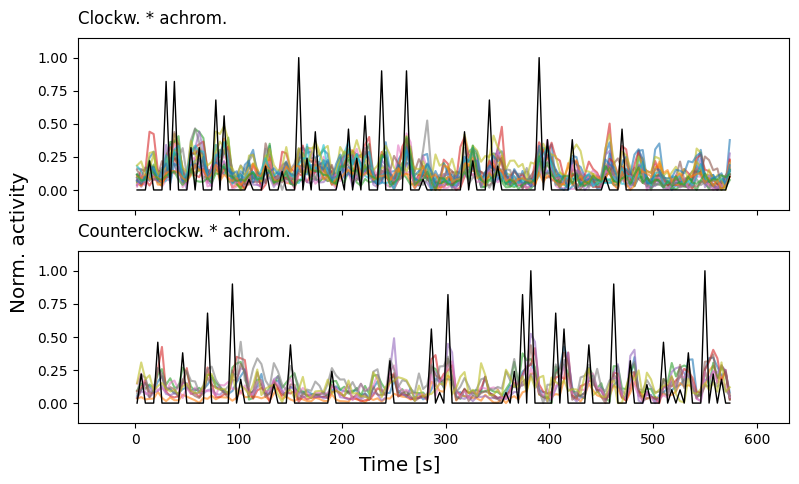

In [17]:
#| code-fold: true

# plot them
idx = np.arange(mf.inx_pmean[0][1]+1)
fig, ax = plt.subplots(2,1, figsize=(20*ps.cm, 12*ps.cm), constrained_layout=True, sharex=True, sharey=True)

ax[0].set_title('Clockw. * achrom.', loc='left')
ax[0].plot(mf.pmean_times[idx], clock_acr[idx], c='k', label='stimulus', zorder=100, lw=1)

for i in range(len(dffs_clock_acr[:,0])):
    clock_acr_dff = dffs_clock_acr[i]
    ax[0].plot(mf.pmean_times[idx], clock_acr_dff[idx]-clock_acr_dff[idx].min(), label = 'dff', alpha = 0.6)

ax[1].set_title('Counterclockw. * achrom.', loc='left')
ax[1].plot(mf.pmean_times[idx], cclock_acr[idx], c='k', label='stimulus', zorder=100, lw=1)

for i in range(len(dffs_cclock_acr[:,0])):
    cclock_acr_dff = dffs_cclock_acr[i]
    ax[1].plot(mf.pmean_times[idx], cclock_acr_dff[idx]-cclock_acr_dff[idx].min(), label = 'dff', alpha = 0.6)

# ax[0].legend()
fig.supxlabel('Time [s]')
fig.supylabel('Norm. activity')

In [18]:
#| output: false

# make threshold
thresh = -0.20

# use threshold to get index
index_clock_acr = index[corr_clock_acr < thresh]
index_cclock_acr = index[corr_cclock_acr < thresh]

# use the index to get the dff data
dffs_clock_acr = active_pmean_dffs[index_clock_acr, :]
dffs_cclock_acr = active_pmean_dffs[index_cclock_acr, :]

Text(0.02, 0.5, 'Norm. activity')

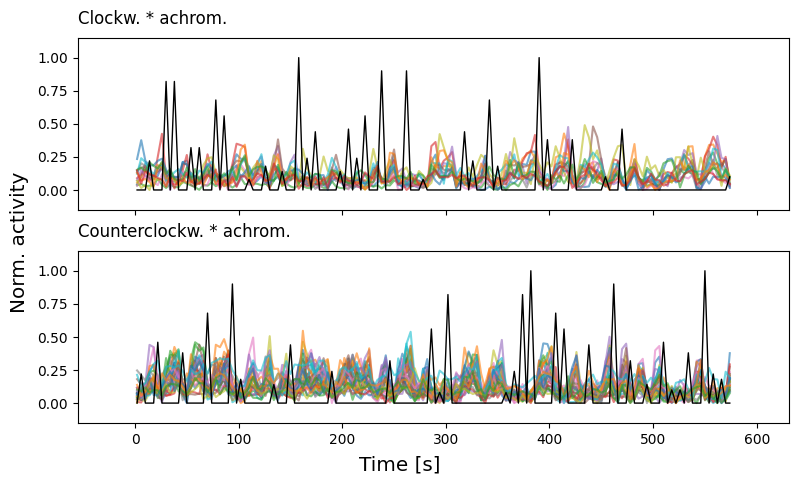

In [19]:
#| code-fold: true

# plot them
idx = np.arange(mf.inx_pmean[0][1]+1)
fig, ax = plt.subplots(2,1, figsize=(20*ps.cm, 12*ps.cm), constrained_layout=True, sharex=True, sharey=True)

ax[0].set_title('Clockw. * achrom.', loc='left')
ax[0].plot(mf.pmean_times[idx], clock_acr[idx], c='k', label='stimulus', zorder=100, lw=1)

for i in range(len(dffs_clock_acr[:,0])):
    clock_acr_dff = dffs_clock_acr[i]
    ax[0].plot(mf.pmean_times[idx], clock_acr_dff[idx]-clock_acr_dff[idx].min(), label = 'dff', alpha = 0.6)

ax[1].set_title('Counterclockw. * achrom.', loc='left')
ax[1].plot(mf.pmean_times[idx], cclock_acr[idx], c='k', label='stimulus', zorder=100, lw=1)

for i in range(len(dffs_cclock_acr[:,0])):
    cclock_acr_dff = dffs_cclock_acr[i]
    ax[1].plot(mf.pmean_times[idx], cclock_acr_dff[idx]-cclock_acr_dff[idx].min(), label = 'dff', alpha = 0.6)

# ax[0].legend()
fig.supxlabel('Time [s]')
fig.supylabel('Norm. activity')

Text(0.02, 0.5, 'Count')

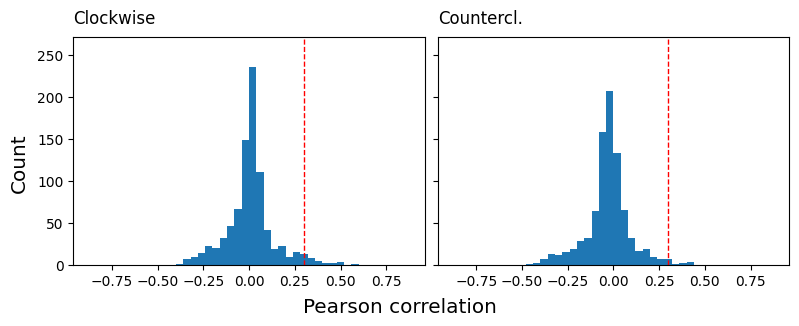

In [20]:
#| output: false

# compute corrs
corr_clock = np.array([pearsonr(x, clock)[0] for x in active_pmean_dffs])
corr_cclock = np.array([pearsonr(x, cclock)[0] for x in active_pmean_dffs])

thresh = 0.3

# plot
fig, ax = plt.subplots(1,2,figsize=(20*ps.cm, 8*ps.cm), sharex=True, sharey = True, constrained_layout = True)
ax[0].hist(corr_clock, bins=40, range=(-0.8,0.8))
ax[0].axvline(thresh, lw=1, c='r', ls='dashed')
ax[1].hist(corr_cclock, bins=40, range=(-0.8,0.8))
ax[1].axvline(thresh, lw=1, c='r', ls='dashed')
ax[0].set_title('Clockwise')
ax[1].set_title('Countercl.')
fig.supxlabel('Pearson correlation')
fig.supylabel('Count')

In [31]:
# get the data
dc = selective_rois_trash(active_pmean_dffs, active_pmean_rois, active_pmean_recs, corr_clock, thresh)
dcc = selective_rois_trash(active_pmean_dffs, active_pmean_rois, active_pmean_recs, corr_cclock, thresh)

Text(0.02, 0.5, 'Mean dff')

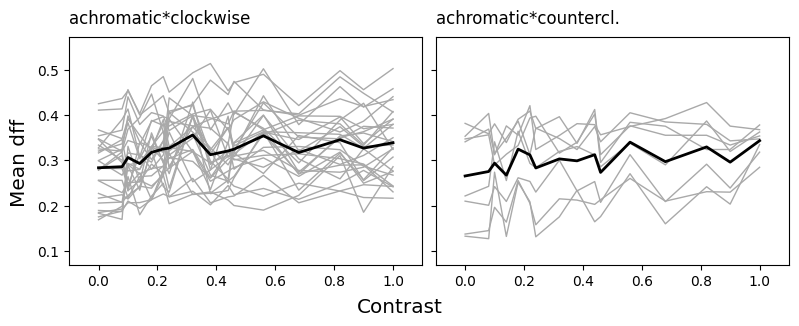

In [32]:
clock_stim = np.array(clock, dtype=float)
cclock_stim = np.array(cclock, dtype=float)

clock_stim[clock_stim == 0] = np.nan
cclock_stim[cclock_stim == 0] = np.nan

acr_clock_stim = clock_stim * acr_contr
acr_cclock_stim = cclock_stim * acr_contr

acr_clock_activity = phase_activity(dc, acr_clock_stim)
acr_cclock_activity = phase_activity(dcc, acr_cclock_stim)

#| output: false

#| code-fold: true
fig, ax = plt.subplots(1,2,figsize=(20*ps.cm, 8*ps.cm),sharex=True,sharey=True, constrained_layout=True)
ax[0].plot(acr_clock_activity.cats, acr_clock_activity.mean_dffs, c='darkgray', lw=1,)
ax[1].plot(acr_cclock_activity.cats, acr_cclock_activity.mean_dffs, c='darkgray', lw=1)

ax[0].plot(acr_clock_activity.cats, np.mean(acr_clock_activity.mean_dffs, axis=1), lw=2, c='k')
ax[1].plot(acr_cclock_activity.cats, np.mean(acr_cclock_activity.mean_dffs, axis=1), lw=2, c='k')

ax[0].set_title('achromatic*clockwise')
ax[1].set_title('achromatic*countercl.')
fig.supxlabel('Contrast')
fig.supylabel('Mean dff')

In [28]:
active_pmean_dffs

array([[0.13327558, 0.12700296, 0.18025564, ..., 0.16376135, 0.13811237,
        0.07504463],
       [0.06732328, 0.04743685, 0.0291388 , ..., 0.06633042, 0.10356917,
        0.08968773],
       [0.26706626, 0.17141007, 0.12709389, ..., 0.4469164 , 0.31910027,
        0.29151757],
       ...,
       [0.44047222, 0.53401111, 0.55297683, ..., 0.13340981, 0.14716655,
        0.1640428 ],
       [0.28865169, 0.30324364, 0.21246633, ..., 0.41392518, 0.37214655,
        0.36580243],
       [0.35061393, 0.50744176, 0.38019213, ..., 0.26875264, 0.30087784,
        0.2821456 ]])

In [29]:
np.shape(active_pmean_dffs)

(857, 432)

In [30]:
dcc.dffs

array([3, 1, 0, 2, 1, 0, 4, 1])